In [1]:
import numpy as np

class PIDController:
    def __init__(self, kp, ki, kd, dt, alpha=0.1):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.alpha = alpha  # learning rate for coefficient adjustment
        self.integral = 0
        self.prev_error = 0
        self.error_window = []  # To store error values for reward function
        self.reward_threshold = 0.1  # For clipping & termination

    def update(self, setpoint, measurement):
        error = setpoint - measurement
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)
        
        # Update previous error
        self.prev_error = error
        self.error_window.append(error**2)  # Storing squared error for reward

        return output

    def optimize(self):
        # Compute average squared error over window
        avg_error = np.mean(self.error_window[-10:])
        reward = 1 / (1 + avg_error)  # Reward function as inverse of error

        if reward > self.reward_threshold:  # Threshold-based adjustment
            return  # Skip optimization if within good range

        # Gradient ascent: Adjust coefficients based on reward gradient
        self.kp += self.alpha * reward * (np.random.uniform(-0.1, 0.1))  # Random noise for exploration
        self.ki += self.alpha * reward * (np.random.uniform(-0.1, 0.1))
        self.kd += self.alpha * reward * (np.random.uniform(-0.1, 0.1))

        # Clip coefficients to prevent drastic changes
        self.kp = max(0, min(10, self.kp))
        self.ki = max(0, min(10, self.ki))
        self.kd = max(0, min(10, self.kd))

        # Reset error window for next iteration
        self.error_window = []

In [2]:
import numpy as np
from ray import train, tune

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step

import gymnasium as gym 
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


In [23]:
hist = []
dt = 0.01
tp = generate_time_period(tn=25, dt=dt)
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)

# Создание заданного сигнала
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=1, output_rad=True), [1, -1])
new_pid = PIDController(kp=1.0, ki=0.5, kd=0.1, dt=0.01)

In [30]:

for _ in tqdm(range(1000)):
    # Настройка модельной среды
    env = gym.make('LinearLongitudinalF16-v0',
                        state_space = ["theta", "q"],
                        control_space =['stab'],
                        output_space = ['theta', 'q'],
                        number_time_steps=number_time_steps, 
                        initial_state=[[0],[0],[0],[0]],
                        reference_signal=reference_signals,
                        tracking_states=["theta"])

    state, info = env.reset()
    # Инициализация ПИД-регулятора


    xt = [0,0]
    # Цикл моделирования среды
    for step in range(number_time_steps - 2):
        setpoint = reference_signals[0, step]
        hist.append(xt[0])
        ut = new_pid.update(setpoint, xt[0])
        xt, reward, terminated, trunkated, info = env.step([ut])
        new_pid.optimize()

100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


In [26]:
new_pid.ki, new_pid.kp, new_pid.kd

(3.2669589527072594e-06, 1.0205053295765674, 0.1552499655422107)

In [27]:
hist = []
dt = 0.01
tp = generate_time_period(tn=25, dt=dt)
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)

# Создание заданного сигнала
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=1, output_rad=True), [1, -1])

# Настройка модельной среды
env = gym.make('LinearLongitudinalF16-v0',
                    state_space = ["theta", "q"],
                    control_space =['stab'],
                    output_space = ['theta', 'q'],
                    number_time_steps=number_time_steps, 
                    initial_state=[[0],[0],[0],[0]],
                    reference_signal=reference_signals,
                    tracking_states=["theta"])

state, info = env.reset()
# Инициализация ПИД-регулятора
pid = PIDController(kp=new_pid.kp, ki=new_pid.ki, kd=new_pid.kd, dt=dt)

xt = [0,0]
# Цикл моделирования среды
for step in range(number_time_steps - 2):
    setpoint = reference_signals[0, step]
    hist.append(xt[0])
    ut = pid.update(setpoint, xt[0])
    xt, reward, terminated, trunkated, info = env.step([ut])

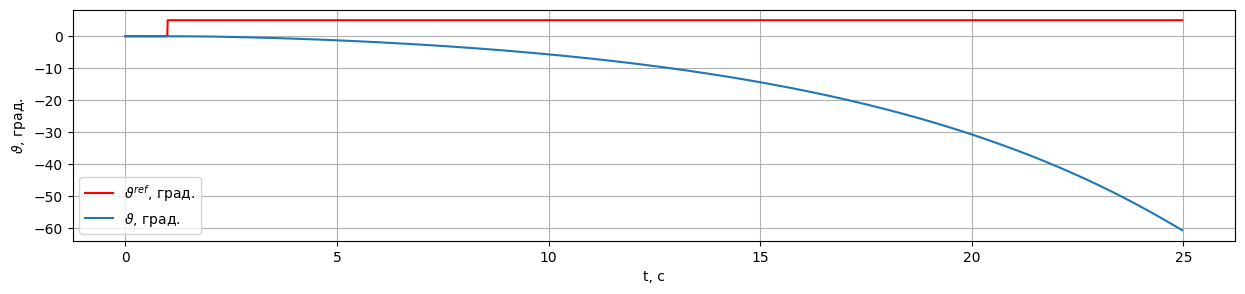

In [28]:
env.unwrapped.model.plot_transient_process(state_name="theta", time=tps, figsize=(15, 3), to_deg=True, ref_signal=reference_signals[0][:2498])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


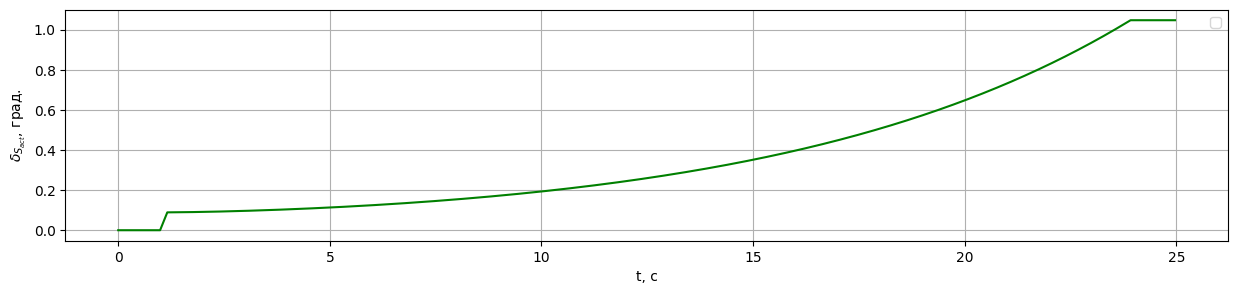

In [29]:
env.unwrapped.model.plot_control(control_name="ele", time=tps, figsize=(15, 3))